<h1 ><big><center>Object recognition and computer vision 2022/2023</center></big></h1>

<h3><big><center><a href="http://www.di.ens.fr/~ponce/">Jean Ponce</a>, <a href="http://www.di.ens.fr/~laptev/">Ivan Laptev</a>, <a href="http://lear.inrialpes.fr/~schmid/">Cordelia Schmid</a> and <a href="http://www.di.ens.fr/~josef/">Josef Sivic</a></center></big></h3>


<h2><big><center> Assignment 3: Bird Classification Kaggle competition</center></big></h2>


</br>

<p align="center">
<img height=300px src="http://www.di.ens.fr/willow/teaching/recvis_orig/assignment3/images/fullyconn.png"/></p>
<p align="center">Figure 1</p>
<p align="center"></p>

**STUDENT**:  Ambroise ODONNAT

**EMAIL**:  ambroise.odonnat@eleves.enpc.fr

## **Import**

In [ ]:
import cv2
import natsort
import os
import shutil
from tqdm import tqdm

import torch
torch.manual_seed(1)  
import torchvision
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import datasets
from torch.autograd import Variable
import torchvision.models as models
import torchvision.transforms as transforms
from torchvision.utils import make_grid
from torch.optim.lr_scheduler import StepLR

import math
import numpy as np
import pandas as pd
import seaborn as sns
import PIL.Image as Image
import matplotlib.pyplot as plt
from skimage.io import imsave
from sklearn.metrics import confusion_matrix , accuracy_score , recall_score, precision_score , f1_score


from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


## **Load Data**

In [ ]:
# Unzip data
os.chdir("/content/drive/MyDrive/MVA/Courses/Object_Recognition_Computer_Vision/TPs/MVA_2022_RecVis_Kaggle") # folder containing the notebook and the data
!ls
# Decomment this line to delete previous dataset and download it again
#!rm -r 'bird_dataset'
#!unzip "bird_dataset.zip"

A3_ODONNAT_Ambroise.ipynb  bird_dataset_cropped  kaggle.csv
bird_dataset		   kaggle_convnext.csv	 models


## **Parameters and variables**

In [ ]:
sns.set

# Paths
path_data = 'bird_dataset' # data folder
path_cropped_data = 'bird_dataset_cropped' # data folder
path_train_data = '/train_images'
path_val_data = '/val_images'
path_test_data = '/test_images'

# Data
image_size = 256 
image_stats = ([0.485, 0.456, 0.406],[0.229, 0.224, 0.225])
num_classes = 20

# Training
use_cuda = torch.cuda.is_available()
RANDOM_SEED = 42
torch.manual_seed(RANDOM_SEED)
batch_size = 32 #for convnext tiny #64 for resnet
features = 512
out_features = 64
fmap_size = 8

## **Visualize Data and Classes**


In [ ]:
set_images = datasets.ImageFolder(path_cropped_data + path_train_data)
print('Size of images:',set_images[0])
train_classes = list(set_images.class_to_idx.keys())
print('Number of classes',len(train_classes))
print('Training Classes:')
train_classes

Size of images: (<PIL.Image.Image image mode=RGB size=446x298 at 0x7F6BF5EBFA50>, 0)
Number of classes 20
Training Classes:


['004.Groove_billed_Ani',
 '009.Brewer_Blackbird',
 '010.Red_winged_Blackbird',
 '011.Rusty_Blackbird',
 '012.Yellow_headed_Blackbird',
 '013.Bobolink',
 '014.Indigo_Bunting',
 '015.Lazuli_Bunting',
 '016.Painted_Bunting',
 '019.Gray_Catbird',
 '020.Yellow_breasted_Chat',
 '021.Eastern_Towhee',
 '023.Brandt_Cormorant',
 '026.Bronzed_Cowbird',
 '028.Brown_Creeper',
 '029.American_Crow',
 '030.Fish_Crow',
 '031.Black_billed_Cuckoo',
 '033.Yellow_billed_Cuckoo',
 '034.Gray_crowned_Rosy_Finch']

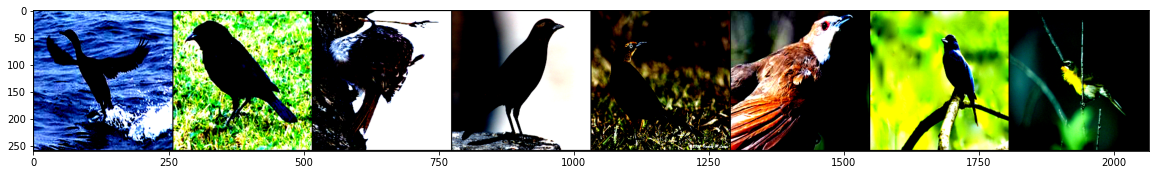

023.Brandt_Cormorant 026.Bronzed_Cowbird 028.Brown_Creeper 009.Brewer_Blackbird 011.Rusty_Blackbird 031.Black_billed_Cuckoo 014.Indigo_Bunting 020.Yellow_breasted_Chat


In [ ]:
def imshow(img):
    """Custom imshow for tensor."""
    img = img.numpy()
    img = np.clip(img,0,1)
    plt.imshow(np.transpose(img, (1, 2, 0)))
    plt.show()

data_transforms = transforms.Compose([transforms.Resize((image_size,image_size)),
                                      transforms.ToTensor(),
                                      transforms.Normalize(*image_stats)
                                      ])

# Gather cropped and original images
set_images = datasets.ImageFolder(path_data + path_train_data,
                                  transform=data_transforms)
set_cropped_images = datasets.ImageFolder(path_cropped_data + path_train_data,
                                  transform=data_transforms)
all_images= torch.utils.data.ConcatDataset([set_images,set_cropped_images])
images_loader = torch.utils.data.DataLoader(all_images,
                                            batch_size=batch_size,
                                            shuffle=True, num_workers=1)
# get some random training images
dataiter = iter(images_loader)
images, labels = dataiter.next()

# Plot N images
N = 8
images, labels = images[:N], labels[:N]
images = torchvision.utils.make_grid(images)
plt.figure(figsize=(20,25))
imshow(images)

# print labels
print(' '.join('%16s' % train_classes[int(labels[j])] for j in range(N)))

### 1. What is striking is the heterogeneity of the images. Birds are not at the same position, the images are not all of same size and the brightness and obstruction of birds can also add a complexity to the problem. 

## Training and Validation Distribution

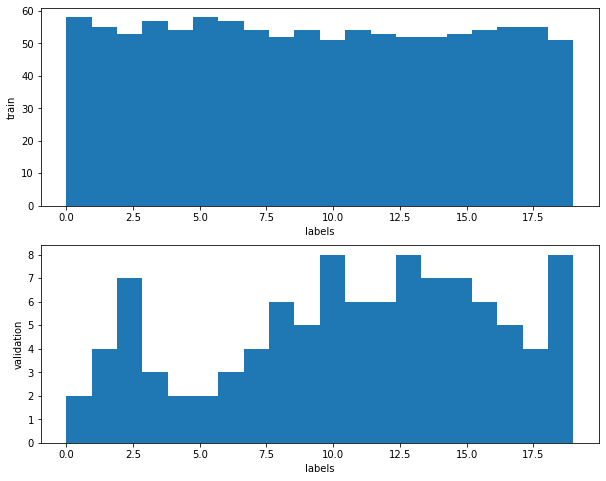

Number of training examples: 1082
Number of validation examples 103


In [ ]:
# The same data distribution goes for original images and cropped images
# Here we plot the distribution for original images
train_images = datasets.ImageFolder(path_data+path_train_data, transform=data_transforms)
val_images = datasets.ImageFolder(path_data+path_val_data, transform=data_transforms)
labels_train = train_images.targets
labels_val = val_images.targets

fig, ax = plt.subplots(2, 1, figsize=(10,8))

ax[0].hist(labels_train, bins=20)  
ax[0].set_ylabel('train')
ax[0].set_xlabel('labels')

ax[1].hist(labels_val, bins=20)  
ax[1].set_ylabel('validation')
ax[1].set_xlabel('labels')
plt.show()

print('Number of training examples:', len(labels_train))
print('Number of validation examples', len(labels_val))

### We have few validation data and we wish to have at least 25% of data in validation to tune the parameters of the model. We will gather training and validation and split it into 75% training and 25% validation.


## **Data Augmentation**
### 2. We saw that we have few data. We use data augmentation methods to avoid overfitting.


### Functions below are inspired from [this notebook](https://github.com/YassineNJ/MVA-Bird-Classification/blob/main/code.ipynb) 

In [ ]:
def square_padding(image):

  """Padding images to make them square to avoid resizing deformation"""


  image = np.array(image).astype( np.uint8)
  width = image.shape[1]
  height = image.shape[0]
  final_shape = max(height,width)
  
  img_target = np.zeros((final_shape, final_shape,3), np.uint8)
  if height == width:
    return Image.fromarray(image)
  elif height > width:
      location = (height-width)/2
      img_target[:,int(location):int(location+width),:] = image
  else:
      location = (width-height)/2
      img_target[int(location):int(location+height),:,:] = image
  return Image.fromarray(img_target)
  
def gaussian_blur(img, kernel_size=(65,65), sigma=1.0):

    """Blurs image with a gaussian filter"""

    image = np.array(img)
    img_target = cv2.GaussianBlur(image,kernel_size,sigma)

    return Image.fromarray(img_target)

### We study below the effect of some of data augmentation technics.

In [ ]:
# We volontarily take high values for the augmented images to highlight their effects
ori_img = Image.open('bird_dataset/train_images/030.Fish_Crow/Fish_Crow_0072_25945.jpg')
gauss_img = gaussian_blur(ori_img,(65,65),5.0)
square_img = square_padding(ori_img)
affine_img = transforms.RandomAffine(20)(ori_img)
flip_img = transforms.RandomHorizontalFlip(p=1)(ori_img)
persp_img = transforms.RandomPerspective(p=1)(ori_img)
erase_img = transforms.ToTensor()(ori_img)
erase_img = transforms.RandomErasing(p=1,inplace=True)(erase_img)
erase_img = np.transpose(erase_img.numpy(), (1, 2, 0))
rot_img = transforms.RandomRotation(20)(ori_img)

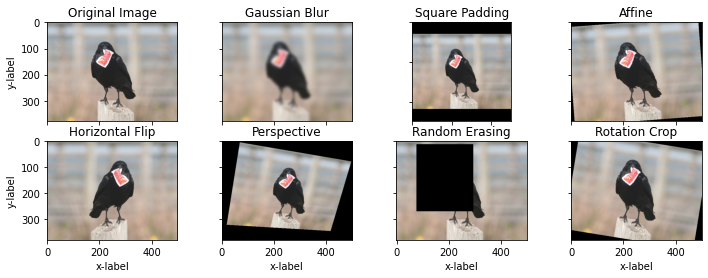

In [ ]:
fig, axs = plt.subplots(2, 4, figsize=(12,4))
axs[0, 0].imshow(ori_img)
axs[0, 0].set_title('Original Image')
axs[0, 1].imshow(gauss_img)
axs[0, 1].set_title('Gaussian Blur')
axs[0, 2].imshow(square_img)
axs[0, 2].set_title('Square Padding')
axs[0, 3].imshow(affine_img)
axs[0, 3].set_title('Affine')
axs[1, 0].imshow(flip_img)
axs[1, 0].set_title('Horizontal Flip')
axs[1, 1].imshow(persp_img)
axs[1, 1].set_title('Perspective')
axs[1, 2].imshow(erase_img)
axs[1, 2].set_title('Random Erasing')
axs[1, 3].imshow(rot_img)
axs[1, 3].set_title('Rotation Crop')

for ax in axs.flat:
    ax.set(xlabel='x-label', ylabel='y-label')

# Hide x labels and tick labels for top plots and y ticks for right plots.
for ax in axs.flat:
    ax.label_outer()


## **Transform Data**
### We choose to apply several augmentation to the training data and add them to the training set.
### Split training and validation data

In [ ]:
augmentation_transforms =  transforms.Compose([
    gaussian_blur,
    transforms.Resize((image_size,image_size)),
    transforms.RandomAffine(20),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ColorJitter(brightness=32./255.,saturation=0.5),
    transforms.RandomRotation(20, resample=Image.BILINEAR),
    transforms.ToTensor(),
    transforms.Normalize(*image_stats, inplace=True),
    transforms.RandomErasing(scale=(0.02, 0.2),inplace=True)
    ])

data_transforms = transforms.Compose([
    transforms.Resize((image_size,image_size)),
    transforms.ToTensor(),
    transforms.Normalize(*image_stats)
    ])

# Gather original and cropped images
train_images = datasets.ImageFolder(path_data + path_train_data,
                                  transform=augmentation_transforms)
train_cropped_images = datasets.ImageFolder(path_cropped_data + path_train_data,
                                  transform=augmentation_transforms)
train_dataset = torch.utils.data.ConcatDataset([train_images,train_cropped_images])
val_images = datasets.ImageFolder(path_data + path_val_data,
                                  transform=data_transforms)
val_cropped_images = datasets.ImageFolder(path_cropped_data + path_val_data,
                                  transform=data_transforms)
val_dataset = torch.utils.data.ConcatDataset([val_images,val_cropped_images])

/usr/local/lib/python3.7/dist-packages/torchvision/transforms/transforms.py:1298: UserWarning: The parameter 'resample' is deprecated since 0.12 and will be removed 0.14. Please use 'interpolation' instead.
  "The parameter 'resample' is deprecated since 0.12 and will be removed 0.14. "


## **Visualization**

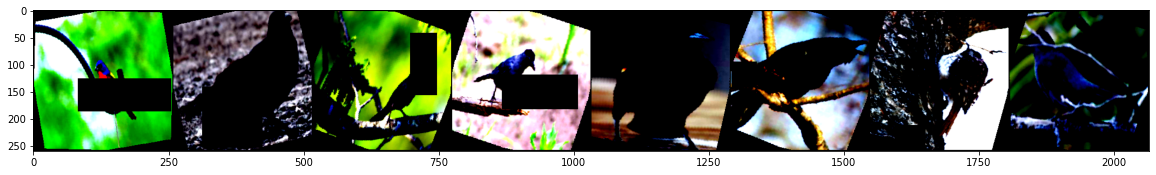

016.Painted_Bunting 029.American_Crow 019.Gray_Catbird 019.Gray_Catbird 010.Red_winged_Blackbird    030.Fish_Crow 028.Brown_Creeper 019.Gray_Catbird


In [ ]:
train_loader = torch.utils.data.DataLoader(train_dataset,
                                           batch_size=batch_size,
                                           shuffle=True, num_workers=1)

val_loader = torch.utils.data.DataLoader(val_dataset,
                                         batch_size=batch_size,
                                         shuffle=False, num_workers=1)

# get some random training images
dataiter = iter(train_loader)
images, labels = dataiter.next()

# Plot N images
N = 8
images, labels = images[:N], labels[:N]
images = torchvision.utils.make_grid(images)
plt.figure(figsize=(20,25))
imshow(images)

# print labels
print(' '.join('%16s' % train_classes[int(labels[j])] for j in range(N)))

## **Model**
### 3. A good idea to have a powerful classifier is to use pre-trained models like proposed in [this article](https://blog.jovian.ai/cnn-and-transfer-learning-with-pytorch-200-bird-species-image-classification-7e1f2e958a78).

## **Pretrained ResNet with a trainable MLP**
### We improve the results by taking a more refined model inspired from [this notebook](https://www.kaggle.com/rajeshbhat/fine-grained-image-classification-with-b-cnn-s)

In [ ]:
class BirdNet34(nn.Module):
    
    def __init__(self):
        super().__init__()

        # Use a pre-trained model
        self.network = models.resnet34(pretrained=True)
        layers = list(self.network.children())[:-2]
        self.features = nn.Sequential(*layers)       

        # Replace last layer
        self.fc = nn.Sequential(
        nn.Linear(features**2,64),
        nn.Tanh(),
        nn.Dropout(0.6),
        nn.Linear(64,num_classes))
    
    def freeze(self):
        # To freeze the residual layers
        for param in self.features.parameters():
            param.require_grad = False

    def unfreeze(self):
        # Unfreeze all layers
        for param in self.features.parameters():
            param.require_grad = True
        
    def forward(self, x):
        N = x.size()[0]
        x = self.features(x)
        x = x.view(N, features, fmap_size ** 2)
        x = torch.bmm(x, torch.transpose(x, 1, 2))/ (fmap_size ** 2) 
        x = x.view(N, features ** 2)
        x = torch.sqrt(x + 1e-5)
        x = F.normalize(x)
        x = self.fc(x)
        
        return x

## **Pretrained ConvNext with a trainable MLP**

In [ ]:
# Best model for our dataset (in validation and test)

class BirdNextTiny(nn.Module):
    
    def __init__(self):
        super().__init__()

        # Use a pre-trained model
        self.network = models.convnext_tiny(pretrained=True)

        # Replace last layer
        in_features = self.network.classifier[2].in_features
        self.network.classifier[2] = nn.Sequential(nn.Linear(in_features,256),
                                                   nn.ReLU(),
                                                   nn.Dropout(0.6),
                                                   nn.Linear(256,num_classes))
     
    def freeze(self):
        # To freeze the residual layers
        for param in self.network.parameters():
            param.require_grad = False
        # To unfreeze the last layer
        for param in self.network.classifier[2].parameters():
            param.require_grad = False  

    def unfreeze(self):
        # Unfreeze all layers
        for param in self.network.parameters():
            param.require_grad = True
        
    def forward(self, x):        
        return self.network(x)

In [ ]:
class BirdNextTiny2(nn.Module):
    
    def __init__(self):
        super().__init__()

        # Use a pre-trained model
        self.network = models.convnext_tiny(pretrained=True)

        # Replace last layer
        in_features = self.network.classifier[2].in_features
        self.network.classifier[2] = nn.Sequential(nn.Linear(in_features,64),
                                                   nn.ReLU(),
                                                   nn.Dropout(0.6),
                                                   nn.Linear(64,num_classes))
     
    def freeze(self):
        # To freeze the residual layers
        for param in self.network.parameters():
            param.require_grad = False
        # To unfreeze the last layer
        for param in self.network.classifier[2].parameters():
            param.require_grad = False  

    def unfreeze(self):
        # Unfreeze all layers
        for param in self.network.parameters():
            param.require_grad = True
        
    def forward(self, x):        
        return self.network(x)

## **Training and Validation**



In [ ]:
def train(epoch, model , optimizer , grad_clip=1, log_interval=1):

    model.train()
    train_loss = 0
    correct = 0

    for batch_idx, (data, target) in enumerate(train_loader):
        
        if use_cuda:
            data, target = data.cuda(), target.cuda()
        
        optimizer.zero_grad()
        output = model(data)
        criterion = torch.nn.CrossEntropyLoss(reduction='mean')
        loss = criterion(output, target)

        train_loss += loss.data.item()

        loss.backward()

        # Gradient clipping
        if grad_clip: 
            nn.utils.clip_grad_value_(model.parameters(), grad_clip)

        optimizer.step()

        # get the index of the max log-probability
        pred = output.data.max(1, keepdim=True)[1]
        correct += pred.eq(target.data.view_as(pred)).cpu().sum()

        if batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.data.item()))
            
    train_loss /= len(train_loader.dataset)
    train_acc = 100. * correct / len(train_loader.dataset)
    print('\nTrain set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)'.format(
        train_loss, correct, len(train_loader.dataset),train_acc))
    
    return train_loss, train_acc


def validation(model, epoch):
  
    model.eval()

    validation_loss = 0
    correct = 0

    for data, target in val_loader:
        if use_cuda:
            data, target = data.cuda(), target.cuda()
        output = model(data)
        
        # sum up batch loss
        criterion = torch.nn.CrossEntropyLoss(reduction='mean')
        validation_loss += criterion(output, target).data.item()

        # get the index of the max log-probability
        pred = output.data.max(1, keepdim=True)[1]
        correct += pred.eq(target.data.view_as(pred)).cpu().sum()

    validation_loss /= len(val_loader.dataset)
    validation_acc = 100. * correct / len(val_loader.dataset)
    print('\nValidation set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)'.format(
        validation_loss, correct, len(val_loader.dataset),validation_acc))
    
    return validation_loss , validation_acc

## **Two stages Training**

Inspired from [Bird Classification Kaggle](https://github.com/EGhamgui/MVA-Courses/blob/main/Rec%20Vis/HM3/A3_GHAMGUI_Eya.ipynb).

In [ ]:
# Parameters
num_epochs = 15 # 15 epochs is good our models
best_loss = np.inf
best_acc = 0
trigger_times = 0
patience = 5
model_path = 'models/convnext_2_ori_cropped_grad_clip_1_epochs.pt'
unfreeze = True
# Hyperparameters
hyperparam = {'lr':1e-4, 'w_decay':1e-5, 'step_size' : 15 , 'gamma' : 0.75, 'grad_clip' : 1} 

In [ ]:
# Lists to store performances 
val_acc_list =[]
val_loss_list = []
train_acc_list =[]
train_loss_list = []

# Define the model
model = BirdNextTiny2()  
use_cuda = torch.cuda.is_available()
if torch.cuda.is_available():
  model.cuda()

optimizer = optim.Adam(params=model.parameters(), lr=hyperparam['lr'], weight_decay=hyperparam['w_decay'])
scheduler = StepLR(optimizer, step_size=hyperparam['step_size'], gamma=hyperparam['gamma'])  
loss_func = nn.CrossEntropyLoss()

################################ First Part ################################

# Freeze the parameters 
model.freeze()

for epoch in range(1, num_epochs + 1):

    for param_group in optimizer.param_groups:
      print("Current learning rate is: {}".format(param_group['lr']))  

    train_loss , train_acc = train(epoch, model , optimizer, hyperparam['grad_clip'])
    val_loss , val_acc = validation(model, epoch)
    
    val_acc_list.append(val_acc)
    val_loss_list.append(val_loss)

    train_acc_list.append(train_acc)
    train_loss_list.append(train_loss)

    scheduler.step()

    if val_acc > best_acc:
      best_acc = val_acc
      torch.save(model.state_dict(), model_path)
      print('model saved in', model_path)

################################ Second Part ################################
if unfreeze:
  print('Unfreeze Parameters')

  # Unfreeze the parameters 
  model.unfreeze()

  for epoch in range(1, num_epochs + 1):

      for param_group in optimizer.param_groups:
        print("Current learning rate is: {}".format(param_group['lr']))  

      train_loss , train_acc = train(epoch, model, optimizer, hyperparam['grad_clip'])
      val_loss , val_acc = validation(model, epoch)
      
      val_acc_list.append(val_acc)
      val_loss_list.append(val_loss)

      train_acc_list.append(train_acc)
      train_loss_list.append(train_loss)

      scheduler.step()
      
      # Early stopping
      if val_acc > best_acc:
        best_acc = val_acc
        torch.save(model.state_dict(), model_path)
        print('model saved in', model_path)

      if val_loss > best_loss:

        trigger_times += 1
        print('trigger times:', trigger_times)

        if trigger_times >= patience:
          print('Early stopping!\nStart to test process.')
          break

      else:
        print('trigger times: 0')
        trigger_times = 0
      
      best_loss = val_loss
 

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ConvNeXt_Tiny_Weights.IMAGENET1K_V1`. You can also use `weights=ConvNeXt_Tiny_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Current learning rate is: 0.0001
Train Epoch: 1 [0/2164 (0%)]	Loss: 3.038889
Train Epoch: 1 [32/2164 (1%)]	Loss: 3.047894
Train Epoch: 1 [64/2164 (3%)]	Loss: 3.005496
Train Epoch: 1 [96/2164 (4%)]	Loss: 3.032720
Train Epoch: 1 [128/2164 (6%)]	Loss: 3.006832
Train Epoch: 1 [160/2164 (7%)]	Loss: 3.002765
Train Epoch: 1 [192/2164 (9%)]	Loss: 2.967023
Train Epoch: 1 [224/2164 (10%)]	Loss: 3.029035
Train Epoch: 1 [256/2164 (12%)]	Loss: 2.986744
Train Epoch: 1 [288/2164 (13%)]	Loss: 2.958040
Train Epoch: 1 [320/2164 (15%)]	Loss: 3.040073
Train Epoch: 1 [352/2164 (16%)]	Loss: 2.987436
Train Epoch: 1 [384/2164 (18%)]	Loss: 2.942210
Train Epoch: 1 [416/2164 (19%)]	Loss: 2.913077
Train Epoch: 1 [448/2164 (21%)]	Loss: 3.013560
Train Epoch: 1 [480/2164 (22%)]	Loss: 2.966000
Train Epoch: 1 [512/2164 (24%)]	Loss: 2.940093
Train Epoch: 1 [544/2164 (25%)]	Loss: 2.963120
Train Epoch: 1 [576/2164 (26%)]	Loss: 3.025061
Train Epoch: 1 [608/2164 (28%)]	Loss: 2.925468
Train Epoch: 1 [640/2164 (29%)]	Loss: 2

## **Visualize loss**

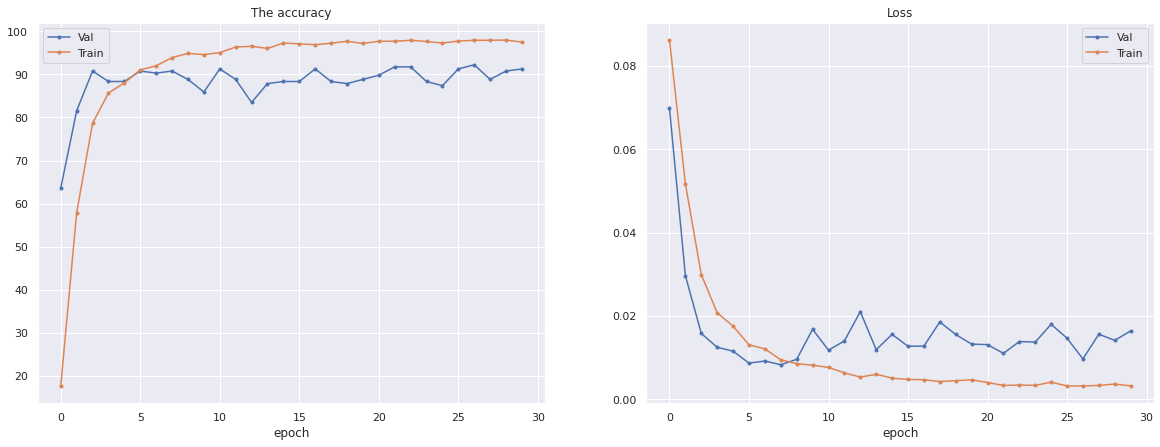

In [ ]:
sns.set()

f, ax = plt.subplots(1, 2 ,figsize=(20,7))
ax[0].plot(range(len(val_acc_list)) , val_acc_list , label= 'Val',marker='.')
ax[0].plot(range(len(train_acc_list)) , train_acc_list , label='Train',marker='.')
ax[0].set_title('The accuracy')
ax[0].legend()
ax[0].set_xlabel('epoch')

ax[1].plot(range(len(val_loss_list)) , val_loss_list , label= 'Val',marker='.')
ax[1].plot(range(len(train_loss_list)) , train_loss_list , label='Train',marker='.')
ax[1].legend()
ax[1].set_title('Loss')
ax[1].set_xlabel('epoch')

plt.show()

In [ ]:
# Recover best model
best_model = BirdNextTiny2()
best_model.load_state_dict(torch.load(model_path)) #best model
if use_cuda:
  best_model.cuda()

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ConvNeXt_Tiny_Weights.IMAGENET1K_V1`. You can also use `weights=ConvNeXt_Tiny_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


## **Confusion Matric**

100%|██████████| 7/7 [00:02<00:00,  3.17it/s]


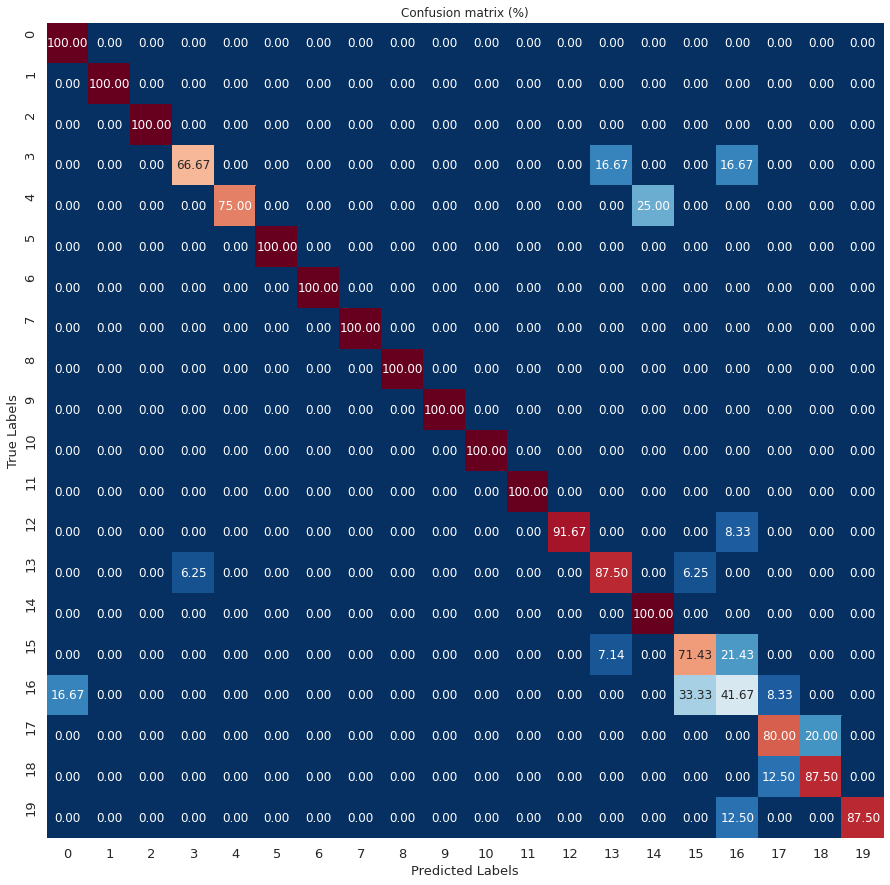

In [ ]:
def display_ConfMat_AccPerClass(y_true,y_preds):
    
    plt.figure(figsize=(15,15))
    conf_mat=confusion_matrix(y_true.numpy(), y_preds.numpy(), normalize='true')
    sns.heatmap(conf_mat * 100 , annot=True, fmt='0.2f',cmap='RdBu_r', cbar=False);
    plt.xlabel('Predicted Labels', fontsize=13);
    plt.ylabel('True Labels', fontsize=13);
    plt.xticks(ticksx,labels, fontsize=13);
    plt.yticks(ticksy,labels, fontsize=13);
    plt.title('Confusion matrix (%)')

    plt.show()

def get_predictions(data_loader):

    y_preds=torch.zeros(0,dtype=torch.long, device='cpu')
    y_true=torch.zeros(0,dtype=torch.long, device='cpu')
    
    with torch.no_grad():
        for x,y in tqdm(data_loader):
            if use_cuda:
                x,y = x.cuda(), y.cuda()
            z = best_model(x)
            _,pred = torch.max(z,1)

            # Append batch prediction results
            y_preds=torch.cat([y_preds,pred.view(-1).cpu()])
            y_true=torch.cat([y_true,y.view(-1).cpu()])
            
    return y_true, y_preds

# Predictions 
y_true_train, y_preds_train = get_predictions(train_loader)
y_true_valid, y_preds_valid = get_predictions(val_loader)

# Confusion matrix
labels=range(num_classes)
ticksx=np.arange(num_classes)+0.5
ticksy=np.arange(num_classes)+0.25
display_ConfMat_AccPerClass(y_true_valid, y_preds_valid)

### The model achieves very good on most of the classes but don't manage to classify well 3 of them. It underlines the fact that our model does not grasp all the details between bird species. 

## **Metrics**

In [ ]:
results = pd.DataFrame(index=np.arange(2), columns=['Set','F1 Score', 'Precision', 'Recall', 'Accuracy'])
base = ['Train','Validation']
i = 0

for (true,pred) in [(y_true_train, y_preds_train), (y_true_valid, y_preds_valid)]:
    p=precision_score(true,pred,average='weighted')
    r=recall_score(true,pred,average='weighted')
    f1=f1_score(true,pred,average='weighted')
    a=accuracy_score(true,pred)
    results.iloc[i]=[base[i]]+[np.round((e *100),4)  for e in [f1,p,r,a]]
    i+=1

results.set_index(['Set'])

,F1 Score,Precision,Recall,Accuracy
Set,,,,
Train,98.1,98.1365,98.1054,98.1054
Validation,89.4002,89.849,89.3204,89.3204


## **Create Test file**

In [ ]:
# Create test file with best model

test_dir = path_cropped_data + '/test_images/mistery_category'

test_data_transforms = transforms.Compose([
    transforms.Resize((image_size,image_size)),
    transforms.ToTensor(),
    transforms.Normalize(*image_stats)
])


def pil_loader(path):
    # open path as file to avoid ResourceWarning (https://github.com/python-pillow/Pillow/issues/835)
    with open(path, 'rb') as f:
        with Image.open(f) as img:
            return img.convert('RGB')

best_model.eval()
output_file = open('kaggle.csv', "w")
output_file.write("Id,Category\n")
for f in tqdm(os.listdir(test_dir)):
    if 'jpg' in f:
        image = pil_loader(test_dir + '/' + f)
        data = test_data_transforms(image)
        data = data.view(1, data.size(0), data.size(1), data.size(2))
        if use_cuda:
            data = data.cuda()
        output = best_model(data)
        pred = output.data.max(1, keepdim=True)[1]
        output_file.write("%s,%d\n" % (f[:-4], pred))

output_file.close()
print('Succesfully wrote kaggle.csv you can upload this file to the kaggle competition website')

100%|██████████| 517/517 [00:13<00:00, 39.51it/s]

Succesfully wrote kaggle.csv you can upload this file to the kaggle competition website
